In [5]:
import tensorflow as tf
import sys

print(f"Versão do TensorFlow: {tf.__version__}")

print(f"TensorFlow construído com CUDA: {tf.test.is_built_with_cuda()}")

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        
        print(f"\nDispositivos lógicos da GPU: {len(logical_gpus)}")
        print("GPU está disponível e sendo utilizada!")
        print(f"Nome da GPU: {tf.test.gpu_device_name()}")

    except RuntimeError as e:
        print(f"\nErro ao configurar a GPU: {e}")
        print("Verifique se os drivers da NVIDIA e o CUDA Toolkit estão instalados corretamente.")
        print("Tentando usar a CPU...")
        
else:
    print("\nNenhuma GPU encontrada. O TensorFlow está usando a CPU.")
    print("Verifique a instalação do TensorFlow e os drivers da GPU.")

Versão do TensorFlow: 2.10.1
TensorFlow construído com CUDA: True

Dispositivos lógicos da GPU: 1
GPU está disponível e sendo utilizada!
Nome da GPU: /device:GPU:0


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') # Para ignorar warnings comuns de bibliotecas


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DataBalanceAnalyzer:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def load_and_analyze_labels(self, labels_df):
        labels = labels_df.iloc[:, 0].values
        counts = Counter(labels)
        print("=== ANÁLISE DE BALANCEAMENTO DOS DADOS PROCESSADOS ===")
        print(f"\nTotal de amostras ({len(labels)}):")
        for label, count in counts.items():
            percentage = (count / len(labels)) * 100
            print(f"  {label}: {count} amostras ({percentage:.2f}%)")
        self.plot_class_distribution(counts)
        return counts

    def plot_class_distribution(self, counts):
        all_classes = list(counts.keys())
        values = [counts.get(cls, 0) for cls in all_classes]
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, len(all_classes)))
        wedges, texts, autotexts = ax.pie(values,
                                          labels=all_classes,
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90)
        ax.set_title('Distribuição das Classes nos Dados Processados')
        plt.tight_layout()
        plt.show()
        total_samples = sum(counts.values())
        min_count = min(counts.values()) if len(counts) > 0 else 1
        imbalance_ratio = max(counts.values()) / (min_count if min_count > 0 else 1)
        print(f"\nEstatísticas de Balanceamento:")
        print(f"Total de amostras: {total_samples}")
        print(f"Razão de desequilíbrio: {imbalance_ratio:.2f}:1")
        if imbalance_ratio > 3:
            print("⚠️  Dataset significativamente desbalanceado! Considere usar:")
            print("  - Class weights no treinamento")
            print("  - Técnicas de oversampling/undersampling")
            print("  - Métricas como F1-score balanceado")


class KB2SPlusModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = layers.Masking(mask_value=0.0)(inputs)
        filters = [128] * 5
        kernel_sizes = [75, 35, 15, 5, 3]
        pool_sizes = [10, 10, 5, 5, 2]
        module_outputs = []
        for i in range(5):
            module_input = x
            conv1 = layers.Conv1D(
                filters=filters[i],
                kernel_size=kernel_sizes[i],
                strides=1,
                padding='same',
                activation='relu',
                name=f'conv1_module_{i+1}'
            )(module_input)
            conv2 = layers.Conv1D(
                filters=filters[i],
                kernel_size=kernel_sizes[i],
                strides=1,
                padding='same',
                activation='relu',
                name=f'conv2_module_{i+1}'
            )(conv1)
            pool = layers.MaxPooling1D(
                pool_size=pool_sizes[i],
                padding='same',
                name=f'pool_module_{i+1}'
            )(conv2)
            module_outputs.append(pool)
            if i > 0:
                concatenated_features = []
                current_shape = pool.shape[1]
                for j, prev_output in enumerate(module_outputs[:-1]):
                    if prev_output.shape[1] != current_shape:
                        if prev_output.shape[1] > current_shape:
                            adapted = layers.MaxPooling1D(
                                pool_size=prev_output.shape[1] // current_shape,
                                name=f'adapt_down_{i}_{j}'
                            )(prev_output)
                        else:
                            repeat_factor = current_shape // prev_output.shape[1]
                            adapted = layers.UpSampling1D(
                                size=repeat_factor,
                                name=f'adapt_up_{i}_{j}'
                            )(prev_output)
                            if adapted.shape[1] != current_shape:
                                adapted = layers.Lambda(
                                    lambda x: x[:, :current_shape, :],
                                    name=f'trim_{i}_{j}'
                                )(adapted)
                    else:
                        adapted = prev_output
                    concatenated_features.append(adapted)
                concatenated_features.append(pool)
                if len(concatenated_features) > 1:
                    x = layers.Concatenate(
                        axis=-1,
                        name=f'concat_module_{i+1}'
                    )(concatenated_features)
                else:
                    x = pool
            else:
                x = pool
        x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)
        x = layers.Dense(256, activation='relu', name='fc1')(x)
        x = layers.Dropout(0.5, name='dropout1')(x)
        x = layers.Dense(128, activation='relu', name='fc2')(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        x = layers.Dense(64, activation='relu', name='fc3')(x)
        x = layers.Dropout(0.2, name='dropout3')(x)
        outputs = layers.Dense(self.num_classes, activation='softmax', name='softmax_output')(x)
        self.model = keras.Model(inputs=inputs, outputs=outputs, name='KB2S_Plus')
        return self.model

    def compile_model(self, learning_rate=0.001):
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return self.model

    def get_model_summary(self):
        if self.model is not None:
            return self.model.summary()
        else:
            print("Modelo não foi construído ainda. Execute build_model() primeiro.")

    def train_model(self, X_train, y_train, X_val, y_val,
                    epochs=100, batch_size=32, class_weights=None):
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7
            )
        ]
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        return self.history

class MetricsEvaluator:
    def __init__(self, class_names):
        self.class_names = class_names

    def calculate_metrics(self, y_true, y_pred):
        precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
        recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        metrics = {
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_weighted': f1_weighted
        }
        return metrics

    def plot_metrics_by_class(self, metrics):
        classes = self.class_names
        precision = metrics['precision_per_class']
        recall = metrics['recall_per_class']
        f1 = metrics['f1_per_class']
        x = np.arange(len(classes))
        width = 0.25
        fig, ax = plt.subplots(figsize=(12, 8))
        bars1 = ax.bar(x - width, precision, width, label='Precisão', alpha=0.8, color='skyblue')
        bars2 = ax.bar(x, recall, width, label='Revocação', alpha=0.8, color='lightcoral')
        bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='lightgreen')
        ax.set_xlabel('Classes')
        ax.set_ylabel('Score')
        ax.set_title('Métricas por Classe (Precisão, Revocação e F1-Score)')
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)
        def add_value_labels(bars):
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        add_value_labels(bars1)
        add_value_labels(bars2)
        add_value_labels(bars3)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Matriz de Confusão')
        plt.xlabel('Predição')
        plt.ylabel('Verdadeiro')
        plt.show()
        return cm

    def print_detailed_report(self, metrics):
        print("\n=== RELATÓRIO DETALHADO DE MÉTRICAS ===")
        print("\n📊 Métricas por Classe:")
        print("-" * 60)
        print(f"{'Classe':<15} {'Precisão':<12} {'Revocação':<12} {'F1-Score':<12}")
        print("-" * 60)
        for i, class_name in enumerate(self.class_names):
            precision = metrics['precision_per_class'][i]
            recall = metrics['recall_per_class'][i]
            f1 = metrics['f1_per_class'][i]
            print(f"{class_name:<15} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")
        print("\n📈 Métricas Médias:")
        print("-" * 40)
        print(f"Precisão Macro:     {metrics['precision_macro']:.4f}")
        print(f"Revocação Macro:    {metrics['recall_macro']:.4f}")
        print(f"F1-Score Macro:     {metrics['f1_macro']:.4f}")
        print()
        print(f"Precisão Ponderada: {metrics['precision_weighted']:.4f}")
        print(f"Revocação Ponderada:{metrics['recall_weighted']:.4f}")
        print(f"F1-Score Ponderado: {metrics['f1_weighted']:.4f}")
        print("\n📝 Interpretação das Métricas:")
        print("• Precisão: Proporção de predições positivas corretas")
        print("• Revocação: Proporção de casos positivos identificados")
        print("• F1-Score: Média harmônica entre precisão e revocação")
        print("• Macro: Média simples entre todas as classes")
        print("• Ponderada: Média ponderada pelo suporte de cada classe")

    def plot_roc_curves(self, y_true, y_pred_proba):
        n_classes = len(self.class_names)
        plt.figure(figsize=(10, 8))

        # Para classificação multiclasse, podemos plotar uma curva ROC para cada classe
        # (abordagem One-vs-Rest)
        for i in range(n_classes):
            # Obter a coluna de probabilidade para a classe atual
            y_score = y_pred_proba[:, i]
            
            # Converter y_true para binário (1 para a classe atual, 0 para as outras)
            y_true_bin = (y_true == i).astype(int)

            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'ROC da Classe {self.class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', label='Linha Aleatória')
        plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
        plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
        plt.title('Curvas ROC por Classe')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
        

    def plot_training_history(self, history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Plotar Acurácia
        ax1.plot(history.history['accuracy'], label='Acurácia de Treinamento')
        ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação')
        ax1.set_title('Histórico de Acurácia')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Acurácia')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plotar Loss
        ax2.plot(history.history['loss'], label='Loss de Treinamento')
        ax2.plot(history.history['val_loss'], label='Loss de Validação')
        ax2.set_title('Histórico de Loss')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

Classes encontradas: ['A' 'N' 'O' '~']
Forma dos dados de treino: (24371, 8000, 1)
Forma dos rótulos de treino: (24371,)
Forma dos dados de validação: (6093, 8000, 1)
Forma dos rótulos de validação (y): (6093,)
Model: "KB2S_Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8000, 1)]    0           []                               
                                                                                                  
 masking_2 (Masking)            (None, 8000, 1)      0           ['input_3[0][0]']                
                                                                                                  
 conv1_module_1 (Conv1D)        (None, 8000, 128)    9728        ['masking_2[0][0]']              
                                                                             

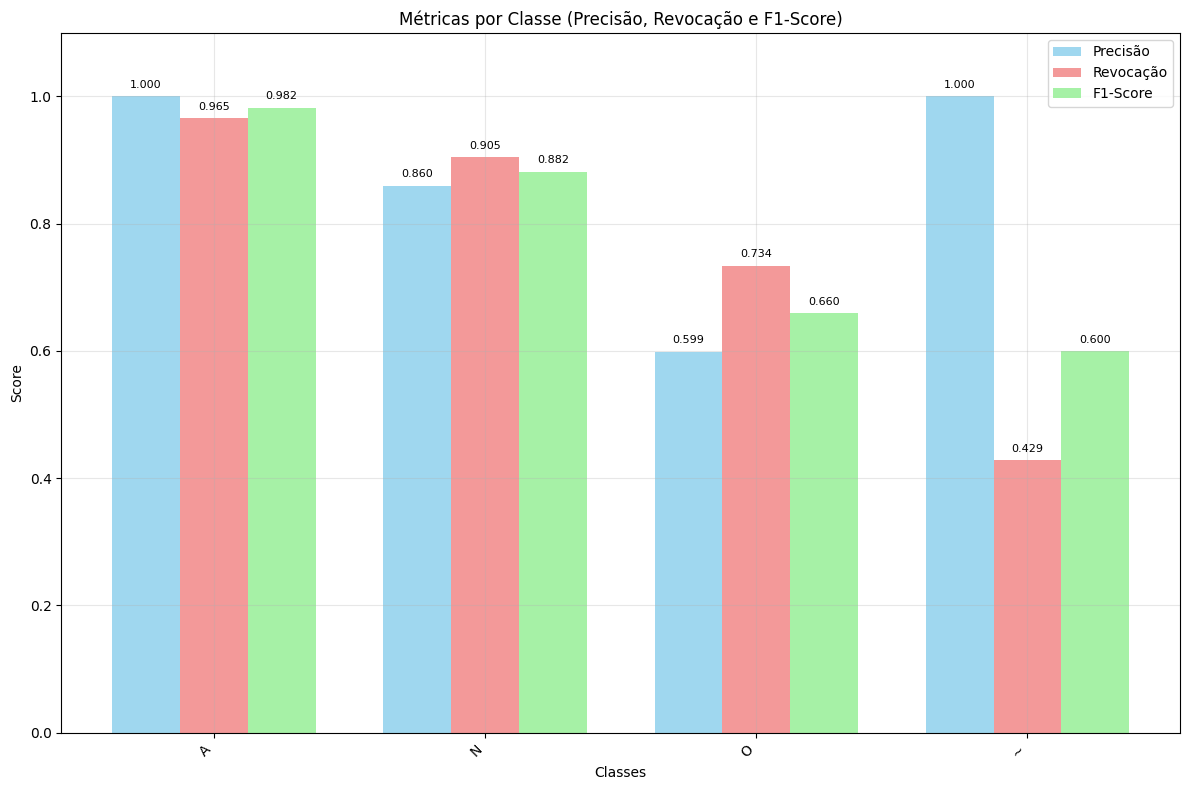

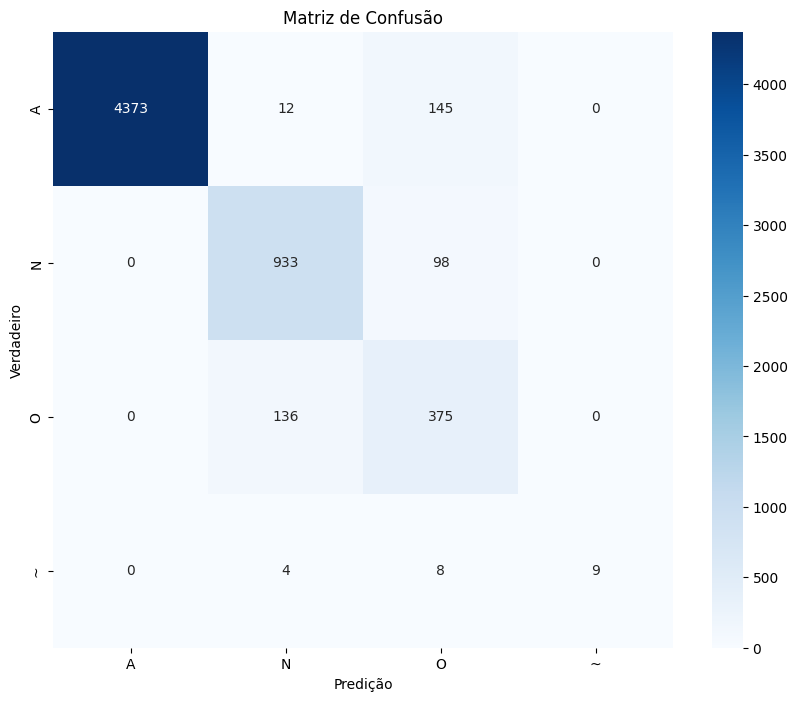


Análise completa finalizada!


In [ ]:
# CÉLULA 2: CARREGAR DADOS, CONSTRUIR MODELO E EXECUTAR TREINAMENTO

# Caminhos para os dados processados (ajuste para o seu diretório real)
PROCESSED_DATA_DIR = "processed_data_balanced/training"
X_path = os.path.join(PROCESSED_DATA_DIR, 'processed_signals.npy')
y_path = os.path.join(PROCESSED_DATA_DIR, 'processed_labels.csv')

X_data = np.load(X_path)
labels_df = pd.read_csv(y_path)

y_labels_raw = labels_df['Label'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels_raw)

if X_data.ndim == 2:
    X_data = np.expand_dims(X_data, axis=-1)

X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

class_names = label_encoder.classes_
num_classes = len(class_names)
print(f"Classes encontradas: {class_names}")
print(f"Forma dos dados de treino: {X_train.shape}")
print(f"Forma dos rótulos de treino: {y_train.shape}")
print(f"Forma dos dados de validação: {X_val.shape}")
print(f"Forma dos rótulos de validação (y): {y_val.shape}")

input_shape = (X_train.shape[1], X_train.shape[2])
model_builder = KB2SPlusModel(input_shape=input_shape, num_classes=num_classes)
model = model_builder.build_model()
model_builder.compile_model(learning_rate=0.001)
model.summary()

class_weights = {}
train_labels_counts = Counter(y_train)
total_samples_train = len(y_train)
max_weight_cap = 3.0  

for i in range(num_classes):
    if train_labels_counts[i] > 0:
        # Calcula o peso normalmente
        weight = total_samples_train / (num_classes * train_labels_counts[i])
        
        class_weights[i] = min(weight, max_weight_cap)
    else:
        class_weights[i] = 0


print(f"\nPesos de classe calculados: {class_weights}")

history = model_builder.train_model(
    X_train, y_train, X_val, y_val,
    epochs=100,
    batch_size=32,
    class_weights=class_weights
)

print("\n--- AVALIAÇÃO FINAL DO MODELO ---")

y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

evaluator = MetricsEvaluator(class_names)
metrics = evaluator.calculate_metrics(y_val, y_pred)
evaluator.print_detailed_report(metrics)
evaluator.plot_metrics_by_class(metrics)
evaluator.plot_confusion_matrix(y_val, y_pred)

print("\nAnálise completa finalizada!")

=== GERANDO GRÁFICOS ADICIONAIS SEM RE-TREINAMENTO ===
Variáveis 'y_val', 'y_pred_proba', 'history' e 'class_names' encontradas na sessão.

Gerando Curvas ROC...


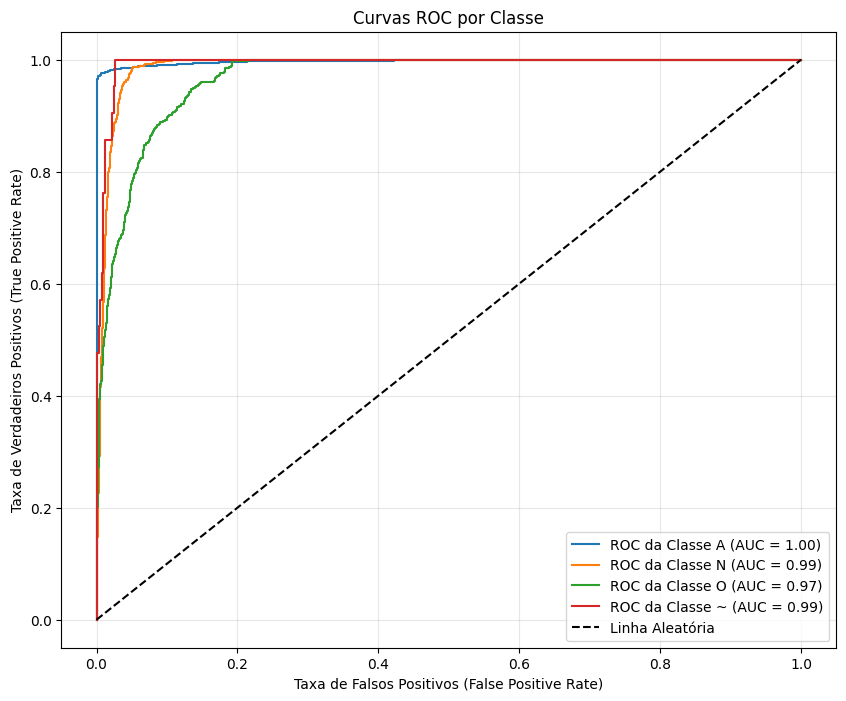

Gerando Histórico de Treinamento (Acurácia e Loss)...


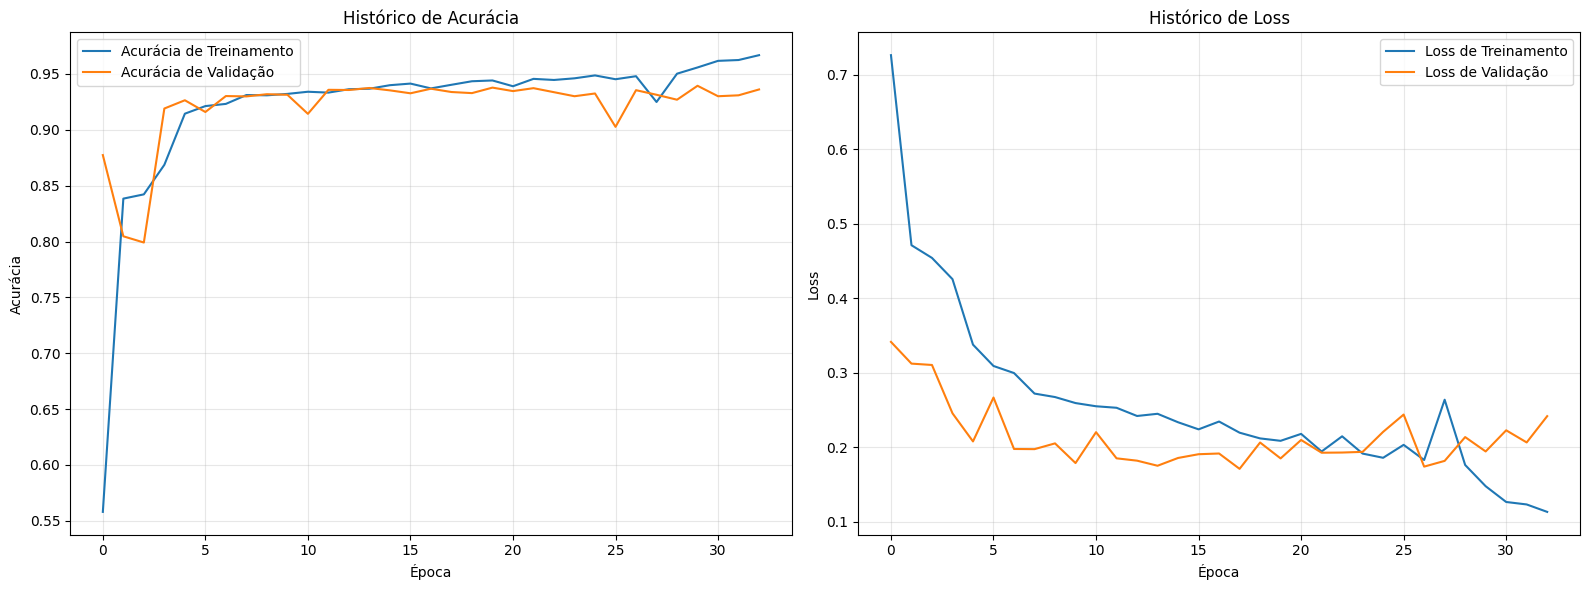


🎉 Geração de gráficos adicionais finalizada!


In [19]:
# Célula para gerar os gráficos sem re-treinar o modelo

print("=== GERANDO GRÁFICOS ADICIONAIS SEM RE-TREINAMENTO ===")

try:
    _ = y_val
    _ = y_pred_proba
    _ = history
    _ = class_names
    print("Variáveis 'y_val', 'y_pred_proba', 'history' e 'class_names' encontradas na sessão.")
except NameError:
    print("ERRO: Algumas variáveis (y_val, y_pred_proba, history, class_names) não foram encontradas.")
    print("Por favor, certifique-se de que a Célula 2 (treinamento e avaliação) foi executada anteriormente.")
    print("Se você reiniciou o kernel, será preciso re-executar as células de carregamento de dados e treinamento para ter essas variáveis.")
    exit() # Ou raise um erro, dependendo do seu ambiente

evaluator = MetricsEvaluator(class_names)


print("\nGerando Curvas ROC...")
evaluator.plot_roc_curves(y_val, y_pred_proba)

print("Gerando Histórico de Treinamento (Acurácia e Loss)...")
evaluator.plot_training_history(history)

print("\n🎉 Geração de gráficos adicionais finalizada!")

In [ ]:
print("=== TENTANDO SALVAR O MODELO TREINADO SEM RE-TREINO ===")

try:
    _ = model_builder
    print("Objeto 'model_builder' encontrado na sessão.")
except NameError:
    print("ERRO: O objeto 'model_builder' não foi encontrado na sua sessão.")
    print("Isso geralmente acontece se você reiniciou o kernel após o treinamento.")
    print("Nesse caso, infelizmente, você precisaria re-executar as etapas de carregamento e treinamento para ter o modelo na memória novamente.")
    exit()


model_save_path = "saved_kb2s_plus_model"

# Chamar o método save_model do seu objeto model_builder já existente e treinado
model_builder.save_model(model_save_path, save_format='tf', include_optimizer=True)

print("\n🎉 Tentativa de salvar o modelo finalizada!")

print("\n--- Verificando o modelo salvo ---")

try:
    loaded_model = tf.keras.models.load_model(model_save_path)
    print(f"Modelo salvo em '{model_save_path}' foi carregado com sucesso para verificação.")
    # Ex: loaded_model.predict(X_val[:1])
except Exception as e:
    print(f"Erro ao carregar o modelo recém-salvo para verificação: {e}")

=== TENTANDO SALVAR O MODELO TREINADO SEM RE-TREINO ===
Objeto 'model_builder' encontrado na sessão.


AttributeError: 'KB2SPlusModel' object has no attribute 'save_model'